### Analisi nelle subreddit

Per valutare se la propensione la verbosità di un interazione utente post varia in funzione della size di un post, analizziamo:
- il numero di utenti univoci in un thread
- la distribuzione della lunghezza (in termini di numero di commenti) delle interazioni

Dividiamo quindi i thread in bins in base alla size, assicurandoci che per ogni bin ci siano almeno 1000 thread dentro, e su questi calcoliamo la distribuzione della lunghezza delle interazioni utente post facendo affidamento al parametro locator per vedere se la verbosità aumenta. (Tagliando le code, mettendo un upper clip per interazioni con più di 10 commenti).

Questo è stato fatto sia dividendo le conversazioni in base a gli anni in cui avvengono sia in base ai subreddit a cui appartengono.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from EXP_package.paper_functions import *
import os
from scipy.stats import entropy as calc_entropy


platform = 'reddit' # Chose 'reddit' , 'voat', 'facebook'
param = 'localizator'  # Choose 'localizator', 'alpha', or 'entropy'
upper_clip =20 # Maximum number of comments counted for an interaction len
bin_size= 25 # Steps of the categorization funcion
min_sample=1000 # Minimum number of observations to plot a point
upper_xlim=300 # Maximum size taken under consideration

df = process_platform(platform, param)




## 3 Location vs size ( number of unique users involved in the thread)

/tmp/ipykernel_9791/2866364681.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_params = data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))


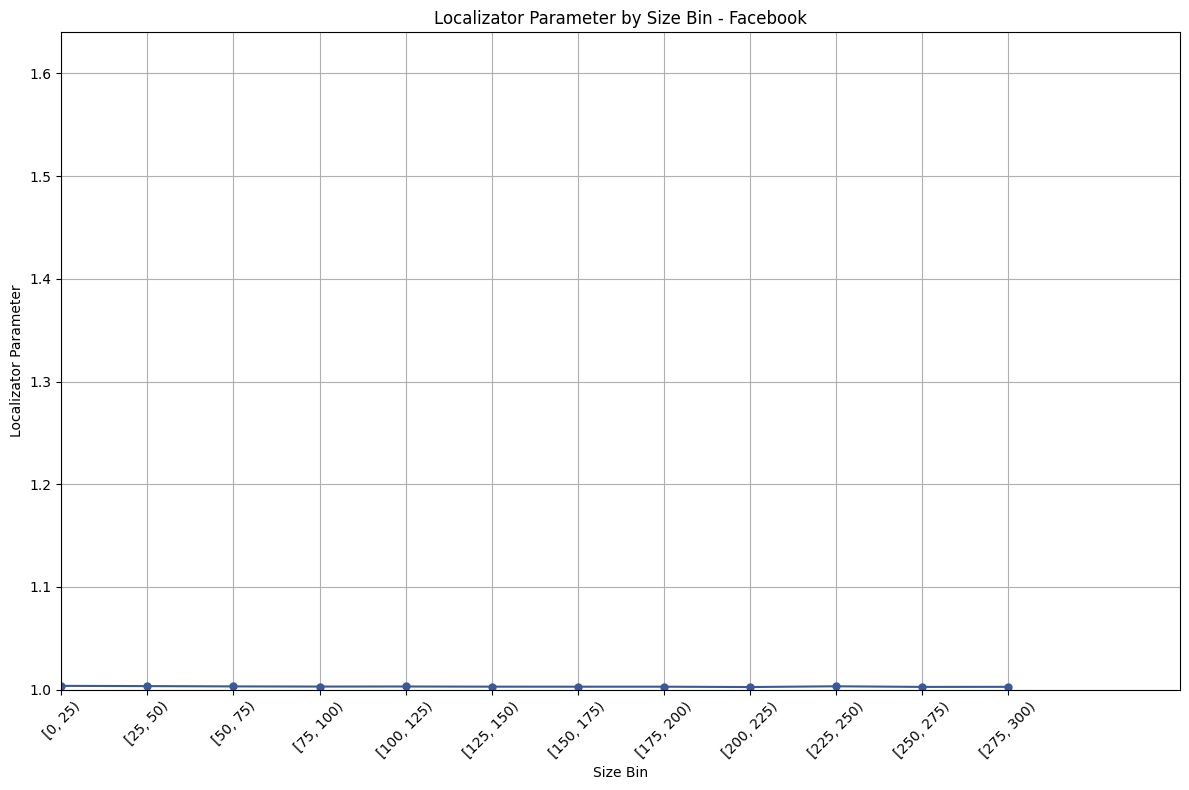

In [157]:
platform_colors = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'gab': '#00c853',
    'Twitter': '#1DA1F2',
    'usenet': '#7D7D7D'
}
color = platform_colors.get(platform, '#000000')

data=df

# Step 1: Calcola il numero di utenti unici per post
unique_user_counts = data.groupby('post_id')['user_id'].nunique().rename('size').reset_index()

# Step 2: Assicurati che le colonne 'post_id' siano dello stesso tipo per l'unione
data['post_id'] = data['post_id'].astype(str)
unique_user_counts['post_id'] = unique_user_counts['post_id'].astype(str)

# Step 3: Unisci i conteggi unici di utenti al dataset originale
data = data.merge(unique_user_counts, on='post_id', how='left')

# Step 4: Raggruppa per utente, post e dimensione, quindi calcola la lunghezza dell'interazione
data = data.groupby(['user_id', 'post_id', 'size']).agg(interaction_len=('user_id', 'count')).reset_index()

# Step 5: Limita la lunghezza delle interazioni a un massimo di 10
data['interaction_len'] = data['interaction_len'].clip(upper=upper_clip)

# Step 6: Definisci i range dei bin per la 'size' e raggruppa i dati in bin
max_size = int(data['size'].max())
if max_size>upper_xlim:
    data=data[data['size']<upper_xlim]
bins = range(0, upper_xlim + bin_size, bin_size)  # Assicurati che la dimensione massima sia inclusa
data['size_bin'] = pd.cut(data['size'], bins=bins, right=False)

# Step 7: Calcola il parametro di localizzazione per ogni bin di dimensioni
if param == 'localizator':
    location_params = data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))
elif param == 'alpha':
    location_params = data.groupby('size_bin')['interaction_len'].apply(calculate_alpha)
elif param == 'entropy':
    location_params = data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_entropy(x.value_counts(normalize=True)))

# Step 8: Filtra i bin con meno di 1000 voci valide
valid_bins = data['size_bin'].value_counts()
plot_data = location_params.copy()
plot_data[valid_bins < min_sample] = None

# Step 9: Plot dei risultati
plt.figure(figsize=(12, 8))
plt.plot(
    plot_data.index.astype(str),  
    plot_data,                  
    marker='o',                
    linestyle='-',  
    color=color,            
    markersize=5,               
    label=f'{param.capitalize()} Parameter'
)

plt.xlabel('Size Bin')              
plt.ylabel(f'{param.capitalize()} Parameter') 
plt.title(f'{param.capitalize()} Parameter by Size Bin - {platform.capitalize()}')
plt.xticks(rotation=45)

# Imposta i limiti dell'asse x
plt.xlim(0, len(bins))  # Imposta il valore massimo dell'asse x
if param == 'localizator':
    plt.ylim(1,1.64) 
elif param == 'alpha':
    plt.ylim(0.6,1 ) 
elif param == 'entropy':
    plt.ylim(0,4) 

plt.tight_layout()
plt.grid(True)
output_file = os.path.join('/home/jacoponudo/Documents/Size_effects/PLT/p4p/size_vs_len/', platform + f'_{param}_plot.png')
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()


In [159]:
import os
from PIL import Image

# Define the path to the folder containing the plots
folder_path = '/home/jacoponudo/Documents/Size_effects/PLT/p4p/size_vs_len'
output_path = '/home/jacoponudo/Documents/Size_effects/PLT/p4p/size_vs_len.jpeg'

# Check if the folder exists
if not os.path.exists(folder_path):
    print(f"Error: The folder '{folder_path}' does not exist.")
else:
    # List all PNG files in the directory
    images = [img for img in os.listdir(folder_path) if img.endswith('.png')]
    
    # Check if there are any images
    if not images:
        print(f"Error: No PNG images found in the folder '{folder_path}'.")
    else:
        # Optional: sort images if needed
        images.sort()
        
        # Load images
        loaded_images = [Image.open(os.path.join(folder_path, img)) for img in images]

        # Calculate the total width and height for the new image
        total_width = sum(img.width for img in loaded_images)
        max_height = max(img.height for img in loaded_images)

        # Create a new blank image
        combined_image = Image.new('RGB', (total_width, max_height))

        # Paste all images into the combined image
        x_offset = 0
        for img in loaded_images:
            combined_image.paste(img, (x_offset, 0))
            x_offset += img.width

        # Save the combined image
        combined_image.save(output_path)

        print(f'Combined image saved at: {output_path}')


Combined image saved at: /home/jacoponudo/Documents/Size_effects/PLT/p4p/size_vs_len.jpeg


### By Year

/tmp/ipykernel_9791/1383554626.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['post_id'] = year_data['post_id'].astype(str)
/tmp/ipykernel_9791/1383554626.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_params = year_data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))
/tmp/ipykernel_9791/1383554626.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

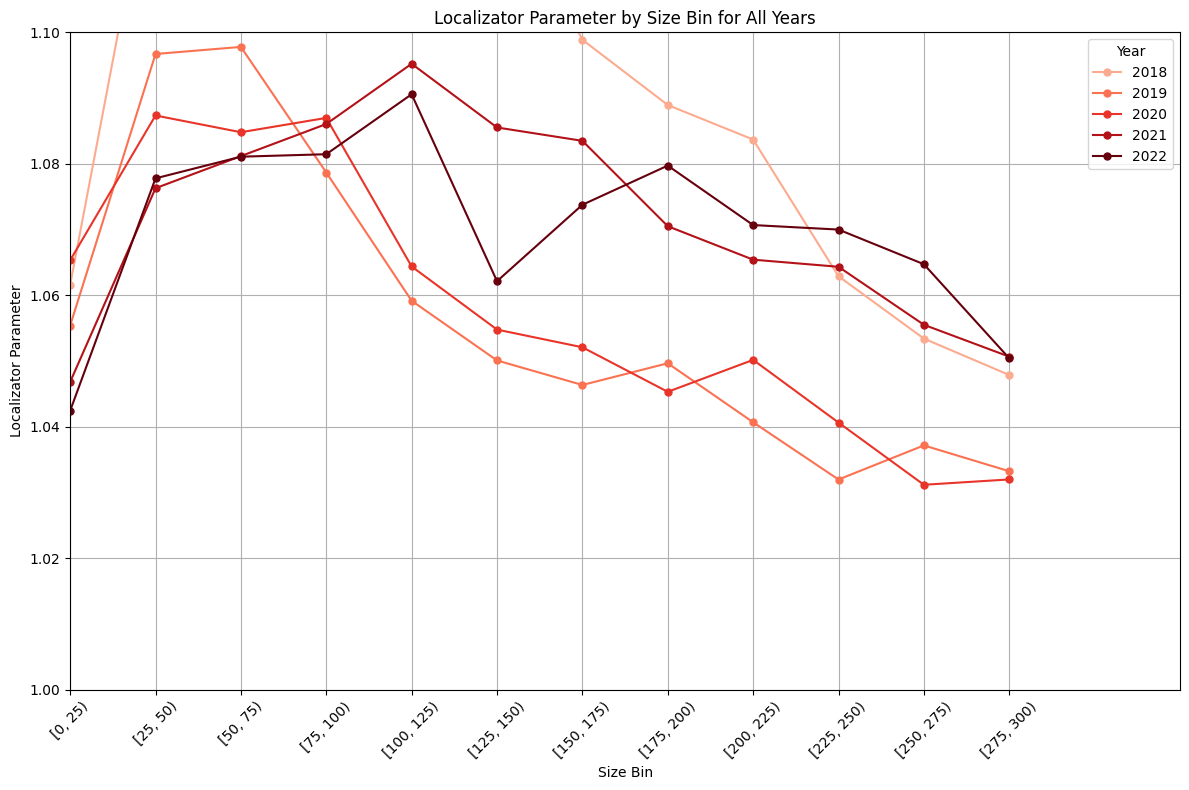

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

data = df  # Assicurati che df sia definito in precedenza
data['year'] = pd.to_datetime(data['date'], errors='coerce').dt.year  # Assicurati che la colonna 'date' sia in formato datetime

# Definisci il colore base e genera sfumature
platform_colors = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'gab': '#00c853',
    'twitter': '#1DA1F2',
    'usenet': '#7D7D7D'
}

# Seleziona il colore di base per la piattaforma
base_color = platform_colors.get(platform, '#000000')

# Ordina gli anni
unique_years = sorted(data['year'].unique())
n_years = len(unique_years)

# Crea una mappa di colori per gli anni, utilizzando una scala di colori differente
colors = plt.cm.Reds(np.linspace(0.3, 1, n_years))  # Crea sfumature di rosso

# Dizionario per memorizzare i parametri di localizzazione per ogni anno
all_years_data = {}

# Cicla attraverso gli anni unici nel dataset
for i, year in enumerate(unique_years):
    year_data = data[data['year'] == year]
    
    # Step 1: Calcola il numero di utenti unici per post
    unique_user_counts = year_data.groupby('post_id')['user_id'].nunique().rename('size').reset_index()

    # Step 2: Assicurati che le colonne 'post_id' siano dello stesso tipo per l'unione
    year_data['post_id'] = year_data['post_id'].astype(str)
    unique_user_counts['post_id'] = unique_user_counts['post_id'].astype(str)

    # Step 3: Unisci i conteggi unici di utenti al dataset originale
    year_data = year_data.merge(unique_user_counts, on='post_id', how='left')

    # Step 4: Raggruppa per utente, post e dimensione, quindi calcola la lunghezza dell'interazione
    year_data = year_data.groupby(['user_id', 'post_id', 'size']).agg(interaction_len=('user_id', 'count')).reset_index()

    # Step 5: Limita la lunghezza delle interazioni a un massimo di 10
    year_data['interaction_len'] = year_data['interaction_len'].clip(upper=upper_clip)
    if len(year_data) == 0:
        continue
    
    # Step 6: Definisci i range dei bin per la 'size' e raggruppa i dati in bin
    max_size = int(year_data['size'].max())
    if max_size > upper_xlim:
        year_data = year_data[year_data['size'] < upper_xlim]
    bins = range(0, upper_xlim + bin_size, bin_size)  # Assicurati che la dimensione massima sia inclusa
    year_data['size_bin'] = pd.cut(year_data['size'], bins=bins, right=False)

    # Step 7: Calcola il parametro di localizzazione per ogni bin di dimensioni
    if param == 'localizator':
        location_params = year_data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))
    elif param == 'alpha':
        location_params = year_data.groupby('size_bin')['interaction_len'].apply(calculate_alpha)
    elif param == 'entropy':
        location_params = year_data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_entropy(x.value_counts(normalize=True)))

    # Step 8: Filtra i bin con meno di 1000 voci valide
    valid_bins = year_data['size_bin'].value_counts()
    plot_data = location_params.copy()
    plot_data[valid_bins < min_sample] = None
    
    # Salva i dati di plot per l'anno corrente
    all_years_data[year] = plot_data

# Step 9: Plot dei risultati per tutti gli anni
plt.figure(figsize=(12, 8))

# Usa le sfumature per ogni anno
for i, (year, plot_data) in enumerate(all_years_data.items()):
    plt.plot(
        plot_data.index.astype(str),  
        plot_data,                  
        marker='o',                
        linestyle='-',  
        color=colors[i],            
        markersize=5,               
        label=f'{year}'
    )

plt.xlabel('Size Bin')              
plt.ylabel(f'{param.capitalize()} Parameter') 
plt.title(f'{param.capitalize()} Parameter by Size Bin for All Years')
plt.xticks(rotation=45)
plt.legend(title='Year')

# Imposta i limiti dell'asse x
plt.xlim(0, len(bins))  # Imposta il valore massimo dell'asse x
if param == 'localizator':
    plt.ylim(1, 1.1) 
elif param == 'alpha':
    plt.ylim(0.6, 1) 
elif param == 'entropy':
    plt.ylim(0, 4) 

plt.tight_layout()
plt.grid(True)
output_file = os.path.join('/home/jacoponudo/Documents/Size_effects/PLT/p4p/size_vs_len_vs_year/', f'{platform}_{param}_all_years_plot.png')
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()


## 4 Comments in the window

In [11]:
import pandas as pd
from tqdm import tqdm
from EXP_package.paper_functions import *

# Define platforms and parameters
platforms = ['reddit', 'voat', 'usenet', 'gab', 'facebook']
sample_size=10000
window_size=120
all_results = []  # List to hold DataFrames from each platform

for platform in platforms:
    # Process the platform data
    df = process_platform(platform)
    
    # Add a new column for the platform name
    df['platform'] = platform
    
    # Process the data further (e.g., window activity)
    results_df = window_activity(df,platform, sample_size, window_size)
    
    # Append the results DataFrame to the list
    all_results.append(results_df)

# Concatenate all DataFrames into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Save the final concatenated DataFrame to a CSV file
final_filename = "/home/jacoponudo/Documents/Size_effects/EXP/Window_Experiment_60min.csv"
final_results_df.to_csv(final_filename, index=False)


KeyboardInterrupt: 

/tmp/ipykernel_13400/1173065470.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = final_results_df.groupby(['platform', 'bins']).size().unstack(fill_value=0)
/tmp/ipykernel_13400/1173065470.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_returned_share = balanced_results_df.groupby(['platform', 'bins'])['user_returned'].mean()


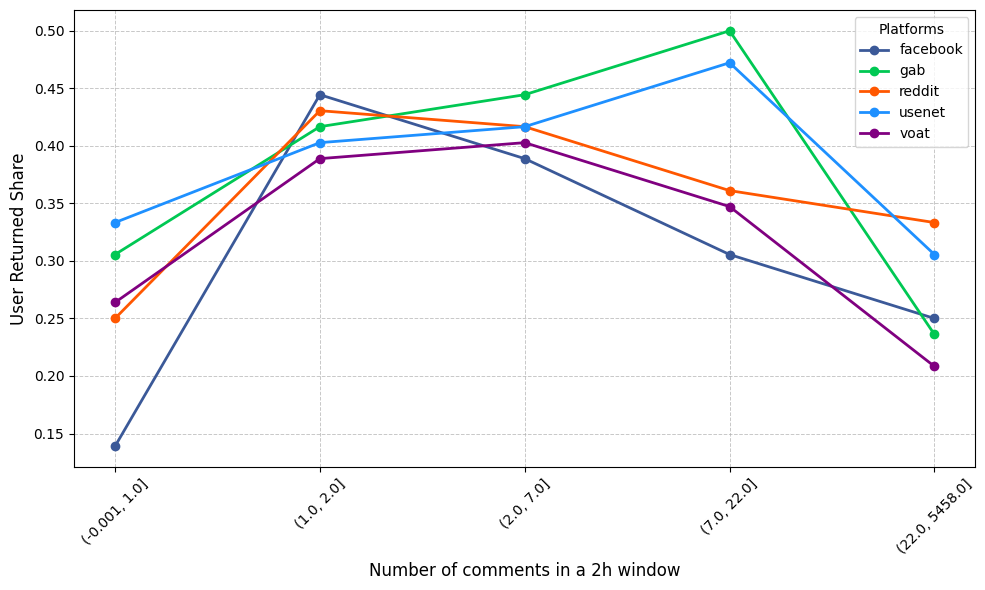

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the final results DataFrame
final_filename = "/home/jacoponudo/Documents/Size_effects/EXP/Window_Experiment_60min.csv"
final_results_df = pd.read_csv(final_filename)
platforms = ['reddit', 'voat', 'usenet', 'gab', 'facebook']
platform_labels = platforms *1000# sample_size  # Repeat each platform 500 times for 2500 values.

# Add the platform labels as a new column
final_results_df['platform'] = platform_labels

# Create bins using quantiles
final_results_df['bins'] = pd.qcut(final_results_df['num_comments_within_10min'], q=6, duplicates='drop')

# Count observations per bin and platform
bin_counts = final_results_df.groupby(['platform', 'bins']).size().unstack(fill_value=0)
min_count_per_bin = bin_counts.min().min()  # Minimum number of observations per bin across platforms

# List to store balanced data
balanced_data = []

# Perform balanced sampling for each platform and bin
for platform in final_results_df['platform'].unique():
    platform_data = final_results_df[final_results_df['platform'] == platform]
    for bin_interval in platform_data['bins'].unique():
        bin_data = platform_data[platform_data['bins'] == bin_interval]
        sampled_data = bin_data.sample(n=min(min_count_per_bin, len(bin_data)), replace=False)
        balanced_data.append(sampled_data)

# Combine the sampled data into a DataFrame
balanced_results_df = pd.concat(balanced_data)

# Calculate the mean for each bin using the balanced DataFrame
user_returned_share = balanced_results_df.groupby(['platform', 'bins'])['user_returned'].mean()

# Reset index for better visualization
df = user_returned_share.reset_index()
df['bins'] = df['bins'].astype(str)

# Define colors for each platform
color_map = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'usenet': '#1E90FF',
    'gab': '#00c853',
    'facebook': '#3b5998'
}

# Plot the results
plt.figure(figsize=(10, 6))

# Iterate over each platform to create the lines of the plot
for platform in df['platform'].unique():
    platform_data = df[df['platform'] == platform]
    plt.plot(platform_data['bins'], platform_data['user_returned'], marker='o', 
             color=color_map.get(platform, '#333333'), linestyle='-', linewidth=2, label=platform)

plt.xlabel('Number of comments in a 2h window', fontsize=12)
plt.ylabel('User Returned Share', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(title='Platforms')

# Save the plot in the same folder as final_filename
plot_filename = os.path.join(os.path.dirname(final_filename), '4_user_returned_share_plot.png')
plt.tight_layout()
plt.savefig(plot_filename)  # Save the plot to the specified path

# Show the plot
plt.show()


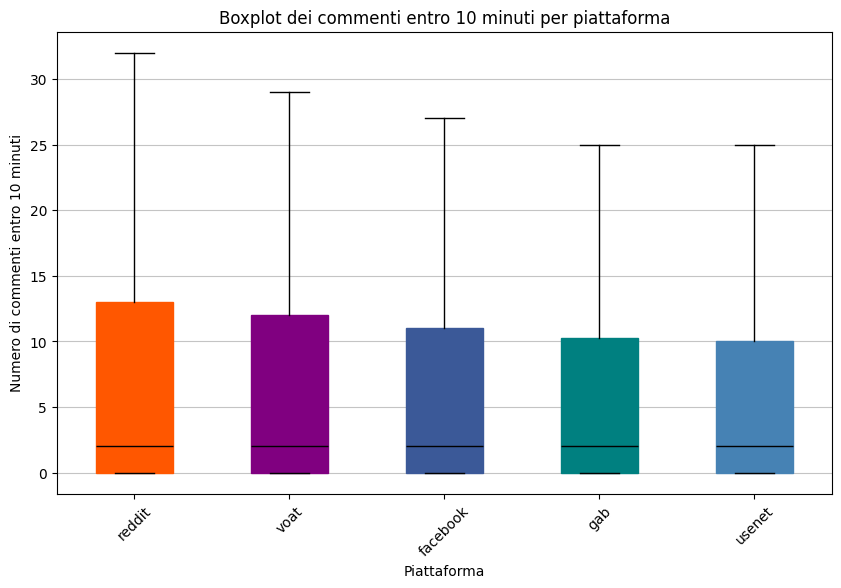

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che 'final_results_df' sia il tuo DataFrame
color_map = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'gab': '#008080',
    'usenet': '#4682B4'
}

# Crea una figura per il boxplot
plt.figure(figsize=(10, 6))

# Crea un boxplot per ogni piattaforma
for platform, color in color_map.items():
    # Filtra i dati per la piattaforma corrente
    data = final_results_df[final_results_df['platform'].str.lower() == platform]['num_comments_within_10min']
    plt.boxplot(data, positions=[list(color_map.keys()).index(platform)], widths=0.5, patch_artist=True, 
                boxprops=dict(facecolor=color, color=color), 
                medianprops=dict(color='black'),showfliers=False)

# Aggiungi dettagli al grafico
plt.title('Boxplot dei commenti entro 10 minuti per piattaforma')
plt.xlabel('Piattaforma')
plt.ylabel('Numero di commenti entro 10 minuti')
plt.xticks(ticks=range(len(color_map)), labels=color_map.keys(), rotation=45)
plt.grid(axis='y', alpha=0.75)

# Mostra il grafico
plt.show()


## 6 FOCUSED VS. EXPANSIONARY THREADS

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from EXP_package.paper_functions import process_platform
from scipy.stats import entropy as calc_entropy
import os

# Parametri
platforms = ['facebook','reddit','voat','gab']  # Scegli le piattaforme

max_distinct_count = 51  
prefix_lengths = range(1, max_distinct_count) 
save_directory = '/home/jacoponudo/Documents/Size_effects/PLT/7_temporal'

# Assicurati che la directory di salvataggio esista
os.makedirs(save_directory, exist_ok=True)

for platform in platforms:
    # Step 1: Processa i dati
    df = process_platform(platform)

    # Step 2: Ordina i dati per post_id e data
    df = df.sort_values(by=['post_id', 'date'])

    # Inizializza la matrice per la heatmap
    heatmap_matrix = np.zeros((len(prefix_lengths), max_distinct_count))
    entropy_values = []

    for idx, k in enumerate(tqdm(prefix_lengths)):
        # Prendi solo i post con almeno k commenti
        eligible_posts = df.groupby('post_id').filter(lambda x: len(x) >= k)
        
        # Prendi solo i primi k commenti di ogni thread
        df_k = eligible_posts.groupby('post_id').head(k)

        # Conta il numero di commentatori distinti nei primi k commenti
        distinct_counts = df_k.groupby('post_id')['user_id'].nunique()

        # Calcola la densità per il numero di commentatori distinti, con un numero fisso di bin
        density, _ = np.histogram(distinct_counts, bins=range(max_distinct_count + 1), density=True)

        # Normalizza la densità per renderla una distribuzione di probabilità
        density = density / density.sum()

        # Calcola l'entropia della distribuzione di probabilità
        if np.any(density):  # Assicurati che ci siano dati per calcolare l'entropia
            ent = calc_entropy(density)
        else:
            ent = 0

        entropy_values.append(ent)

        # Inserisci la densità nella matrice
        heatmap_matrix[idx, :] = density

    # Step 4: Visualizza la mappa di calore
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_matrix.T, cmap='viridis_r', origin='lower')  # Invertito
    plt.colorbar(label='Densità relativa')
    plt.xlabel('Lunghezza del prefisso k')
    plt.ylabel('Numero di Partecipanti Distinti d')
    plt.title(f'Mappa di Calore per {platform.capitalize()}')
    
    # Salva il plot
    plt.savefig(os.path.join(save_directory, f'heatmap_{platform}.png'), bbox_inches='tight')
    plt.close()  # Chiudi la figura dopo il salvataggio


 28%|██▊       | 14/50 [01:01<02:37,  4.37s/it]


KeyboardInterrupt: 

## 1 Distribution of interaction len 

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from EXP_package.paper_functions import process_platform

# Define the platforms to compare
platforms = ['reddit', 'voat', 'facebook', 'gab', 'usenet']

# Define the output directory and ensure it exists
output_dir = '/home/jacoponudo/Documents/Size_effects/PLT/p4p'
os.makedirs(output_dir, exist_ok=True)
jpeg_path = os.path.join(output_dir, 'platform_histograms.jpeg')

# Initialize a dictionary to store interaction counts for each platform
platform_data = {}

# Process each platform and store interaction counts
for platform in platforms:
    df = process_platform(platform)
    # Count user interactions per post
    counts = df.groupby(['user_id', 'post_id'])['date'].count().reset_index(name='interaction_count')
    platform_data[platform] = counts['interaction_count']

# Define histogram bins and color map for the platforms
bins = np.arange(1, 11, 1)
color_map = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'gab': '#008080',
    'usenet': '#4682B4'
}

# Create subplots for each platform
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()  # Flatten the 3x2 array of axes for easy indexing

localization_values = {}

for i, (ax, platform) in enumerate(zip(axes, platforms)):
    data = platform_data[platform]
    
    # Calculate histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    
    # Plot the histogram
    ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), 
           color=color_map[platform], alpha=0.8, align='edge')

    # Add a vertical line at x=1 (grey line)
    ax.axvline(x=1, color='grey', linestyle='-', linewidth=2)
    
    # Calculate and plot the localization parameter
    loc_param = calculate_localization_parameter(hist)
    ax.axvline(x=loc_param, color='yellow', linestyle='-', linewidth=1, label='Localization Parameter')

    # Set title and labels
    ax.set_title(f'{platform.capitalize()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Relative Frequency', fontsize=12)
    ax.set_xlabel('Number of Comments in an Interaction', fontsize=12)
    ax.set_ylim(0, 1)  # Adjust y-limits for clarity

    # Store localization parameter for printing later
    localization_values[platform] = loc_param

    # Add legend to the first subplot only
    if i == 0:
        ax.legend()

# Set the x-axis label and ticks
plt.xticks(bins)
plt.ylim(0.5, 1)  # Set a uniform y-limit across the plots

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(jpeg_path, format='jpeg', dpi=300)
plt.close()

# Print localization values
for platform, value in localization_values.items():
    print(f'Localization parameter for {platform.capitalize()}: {value:.4f}')

print(f'Plot saved as JPEG to {jpeg_path}')


Localization parameter for Reddit: 1.0654
Localization parameter for Voat: 1.0413
Localization parameter for Facebook: 1.0027
Localization parameter for Gab: 1.0347
Localization parameter for Usenet: 1.1043
Plot saved as JPEG to /home/jacoponudo/Documents/Size_effects/PLT/p4p/platform_histograms.jpeg


## 2 Localization Parameter

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from EXP_package.paper_functions import process_platform
import os

# Define the platforms you want to compare
platforms = ['reddit', 'voat', 'facebook', 'gab', 'usenet']

# Define the directory where to save the PDF
output_dir = '/home/jacoponudo/Documents/Size_effects/PLT/p4p'  # Replace with your desired directory
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Initialize a list to store the localization data
localization_data = []

# Process each platform and store the results
for platform in platforms:
    df = process_platform(platform)
    # Extract year and month from the date column
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    # Drop rows where date conversion failed
    df = df.dropna(subset=['year', 'month'])
    
    # Get unique years
    years_unique = df['year'].unique()
    
    for year in years_unique:
        for month in range(1, 13):  # Loop through each month
            # Filter data for the specific year and month
            monthly_data = df[(df['year'] == year) & (df['month'] == month)]
            
            # Check if there are at least 500 rows in the monthly dataset
            if len(monthly_data) < 500:
                continue  # Skip this month if there are fewer than 500 rows
            
            # Group by user and post to count the occurrences of comments (or other interactions)
            counts = monthly_data.groupby(['user_id', 'post_id'])['date'].count().reset_index()
            
            # Calculate histogram for PDF
            hist, _ = np.histogram(counts['date'], bins=np.arange(1, 11, 1), density=True)
            
            # Calculate the Localization parameter L (replace with your actual calculation)
            localization_value = calculate_localization_parameter(hist)  # Ensure this function is defined
            
            # Create a datetime object for the x-axis
            date_str = f"{int(year)}-{month:02d}-01"  # Ensure year is an integer
            localization_data.append({'Platform': platform, 
                                       'Date': pd.to_datetime(date_str),  # Convert to datetime
                                       'Localization': localization_value})

# Convert to DataFrame
localization_df = pd.DataFrame(localization_data)

# Sort the DataFrame by Date
localization_df = localization_df.sort_values(by='Date').reset_index(drop=True)

# Define the color map for the platforms
color_map = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'gab': '#008080',  
    'usenet': '#4682B4'  
}

# Create the scatter plot
plt.figure(figsize=(12, 6))
for platform in platforms:
    subset = localization_df[localization_df['Platform'] == platform]
    plt.scatter(subset['Date'], 
                subset['Localization'], label=platform.capitalize(), 
                color=color_map[platform], alpha=0.7)

# Add labels, title, and legend
plt.title('Localization Parameter Over Time by Social Platform', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Localization Value', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Platform', fontsize=12, title_fontsize=13)
plt.tight_layout()

# Save the scatter plot
plt.savefig(os.path.join(output_dir, 'localization_scatter_plot.png'))
plt.close()

print(f'Scatter plot saved to {output_dir}/localization_scatter_plot.png')


Scatter plot saved to /home/jacoponudo/Documents/Size_effects/PLT/p4p/localization_scatter_plot.png


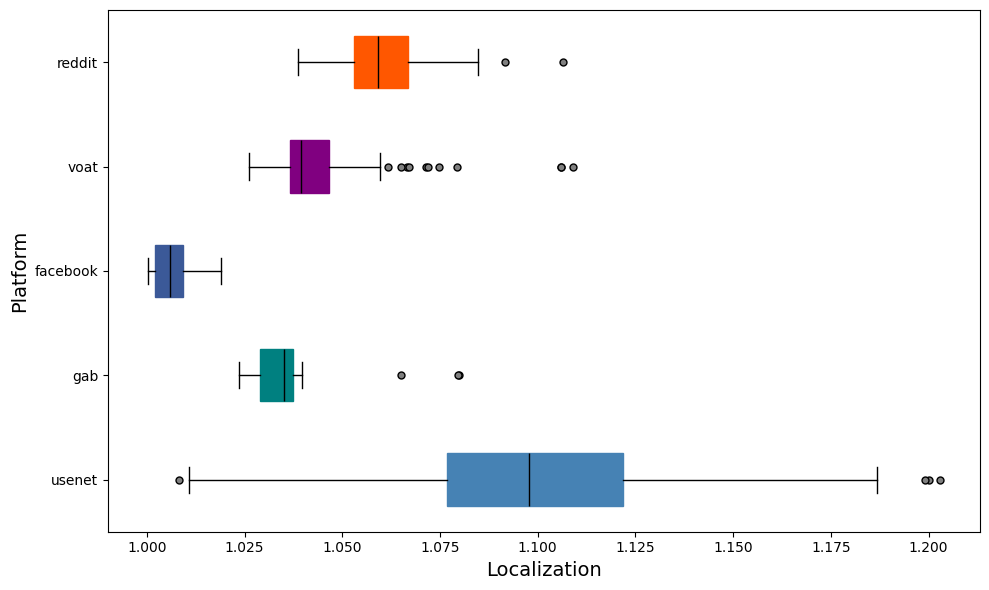

In [8]:
import matplotlib.pyplot as plt

# Mappa colori
color_map = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'gab': '#008080',
    'usenet': '#4682B4'
}

# Inverti l'ordine delle piattaforme
platforms = list(color_map.keys())[::-1]  # Inverte l'ordine delle piattaforme

# Crea il boxplot
plt.figure(figsize=(10, 6))

# Disegna i boxplot orizzontali
boxplots = plt.boxplot(
    [localization_df[localization_df['Platform'] == platform]['Localization'] for platform in platforms],
    positions=list(range(len(platforms))), 
    patch_artist=True,  # Abilita il colore per i box
    flierprops=dict(markerfacecolor='grey', markersize=5),
    vert=False  # Abilita i boxplot orizzontali
)

# Colorare i boxplot
for patch, platform in zip(boxplots['boxes'], platforms):
    patch.set_facecolor(color_map[platform])
    patch.set_edgecolor(color_map[platform])  # Imposta il colore del bordo

# Imposta il colore della mediana
for median in boxplots['medians']:
    median.set_color('black')

# Aggiungi le etichette e i titoli
plt.title('', fontsize=16, fontweight='bold')
plt.ylabel('Platform', fontsize=14)
plt.xlabel('Localization', fontsize=14)
plt.yticks(ticks=range(len(platforms)), labels=platforms)  # Cambia le etichette per l'asse y
plt.grid(False)

# Salva il grafico
plt.tight_layout()  # Ottimizza la disposizione
plt.savefig('/home/jacoponudo/Documents/Size_effects/PLT/p4p/localization_vs_platform.png')  # Specifica il percorso e il nome del file

# Mostra il grafico
plt.show()
